In [1]:
# pip install azure-ai-textanalytics

In [2]:
import os

# This example requires environment variables named "LANGUAGE_KEY" and "LANGUAGE_ENDPOINT"
language_key = os.environ.get('LANGUAGE_KEY')
# "411dab1a118f4719bf8f48d8b4dc5cc1"
language_endpoint = os.environ.get('LANGUAGE_ENDPOINT')
# "https://nlpoc.cognitiveservices.azure.com/"

In [3]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [4]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(language_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=language_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [5]:
# 2. Fonction pour analyser le sentiment d'un texte
def sentiment_analysis(client, documents):
    sentiments = []
    batch_size = 10  # Azure ne permet pas plus de 10 documents par requête

    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]  # Diviser les documents en lots de 10
        response = client.analyze_sentiment(documents=batch)
        for doc in response:
            if not doc.is_error:
                sentiment = 1 if doc.sentiment == "positive" else 0
                sentiments.append(sentiment)
            else:
                sentiments.append(None)  # Pour gérer les erreurs éventuelles
    return sentiments

In [6]:
# 3. Analyser le dataframe
def add_sentiment_column(data, column):
    client = authenticate_client()
    documents = data[column].tolist()  # Extraire les textes à analyser
    sentiments = sentiment_analysis(client, documents)  # Analyser le sentiment
    
    new_column_name = f"azure_sentiment_{column}"  # Concaténer azure_sentiment avec le nom de la colonne
    data[new_column_name] = sentiments  # Ajouter les résultats comme nouvelle colonne
    
    return data

In [7]:
import pandas as pd
data = pd.read_csv("./data/test_df.csv", index_col=0)

In [8]:
# Ajouter la colonne 'sentiment'
data = add_sentiment_column(data, "text")
data.head()

,target,ids,date,flag,user,text,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,sia_sentiment,azure_sentiment_text
804631,1,1468543949,Tue Apr 07 02:19:08 PDT 2009,NO_QUERY,OhFlip_Eden,Haha flight of the conchords was so bloody hil...,"Haha, flight of the conchords was so bloody hi...","['Haha', ',', 'flight', 'of', 'the', 'conchord...",haha flight conchords bloody hilarious last n...,"['haha', 'flight', 'conchords', 'bloody', 'hil...",1,1
260113,0,1985592824,Sun May 31 17:24:11 PDT 2009,NO_QUERY,basvodde,In Singapore airport again. On my way to Tokyo...,In Singapore airport again. On my way to Tokyo...,"['In', 'Singapore', 'airport', 'again', '.', '...",singapore airport way tokyo always tired sta...,"['singapore', 'airport', 'way', 'tokyo', 'alwa...",0,0
1325504,1,2015141263,Wed Jun 03 03:49:42 PDT 2009,NO_QUERY,RocketIsRad,@curtiswalker finally responded to your DN mes...,<mention> finally responded to your DN message...,"['<', 'mention', '>', 'finally', 'responded', ...",< mention > finally responded dn messagesorry ...,"['<', 'mention', '>', 'finally', 'responded', ...",0,0
495301,0,2185191785,Mon Jun 15 17:01:14 PDT 2009,NO_QUERY,Holden_n_Disney,Boarding @jetblue 1424. Sad to leave Cali and ...,Boarding <mention> 1424. Sad to leave Cali and...,"['Boarding', '<', 'mention', '>', '1424', '.',...",boarding < mention > 1424 sad leave cali dad,"['boarding', '<', 'mention', '>', '1424', 'sad...",0,0
170271,0,1962864508,Fri May 29 11:49:11 PDT 2009,NO_QUERY,ProTravelGear,@kgs lost luggage? Sorry to hear. you should...,<mention> lost luggage? Sorry to hear. You sh...,"['<', 'mention', '>', 'lost', 'luggage', '?', ...",< mention > lost luggage ? sorry hear check s...,"['<', 'mention', '>', 'lost', 'luggage', '?', ...",0,0


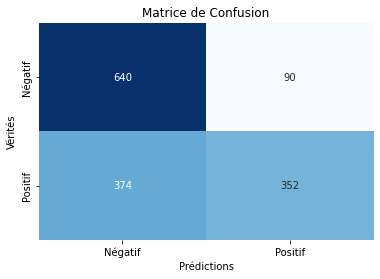

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.63      0.88      0.73       730
     Positif       0.80      0.48      0.60       726

    accuracy                           0.68      1456
   macro avg       0.71      0.68      0.67      1456
weighted avg       0.71      0.68      0.67      1456



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    print("Rapport de Classification:\n")
    print(report)

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification
print_classification_report(data)

In [11]:
# Ajouter la colonne 'sentiment'
data = add_sentiment_column(data, "preprocessed_text")

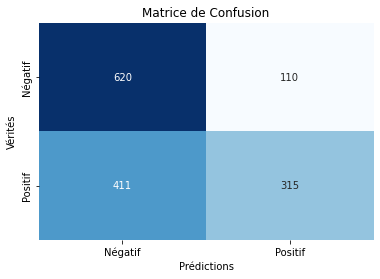

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.60      0.85      0.70       730
     Positif       0.74      0.43      0.55       726

    accuracy                           0.64      1456
   macro avg       0.67      0.64      0.63      1456
weighted avg       0.67      0.64      0.63      1456



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    print("Rapport de Classification:\n")
    print(report)

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification
print_classification_report(data)

Il y a peu de faux positifs, et l'algorithme réagit mieux au texte non prétraité. La performance est meilleure que celle des bibliothèques OpenSource sur étagère.

In [13]:
data.to_csv("./data/test_azure.csv", index=True)